<a href="https://colab.research.google.com/github/dinakeshvari/Intro_Transformers/blob/main/Intro_to_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Overview of Transformer Architecture:**

Transformers are based on the self-attention mechanism and are designed to handle sequential data. Unlike RNNs and LSTMs, Transformers do not rely on sequential data processing, making them highly parallelizable and better suited for large datasets.

The Transformer architecture can be divided into encoder and decoder blocks, although models like BERT use just the encoder, and models like GPT use only the decoder. Here’s a high-level breakdown:


1.   Input Embedding: Converts the input tokens (words, sentences, etc.) into a dense vector space.

2.   Positional Encoding: Adds information about the position of each token, since transformers do not have inherent sequence information.
3.   Multi-Head Self-Attention: Captures relationships between all tokens in a sequence, allowing the model to focus on different parts of the input simultaneously.
4.   Feed Forward Network: A fully connected neural network applied to each token independently.
5.   Residual Connections and Layer Normalization: Enhances training by connecting layers and normalizing inputs.
6.   Encoder and Decoder Blocks: Encoders process input data, and decoders generate the output sequence, often with attention to encoder outputs.

***You may consider checking out the StatQuest video on "transformers" before getting through the codes for Visual comprehension!***
[StatQuest video on "transformers"](https://www.youtube.com/watch?v=zxQyTK8quyY&t=19s)

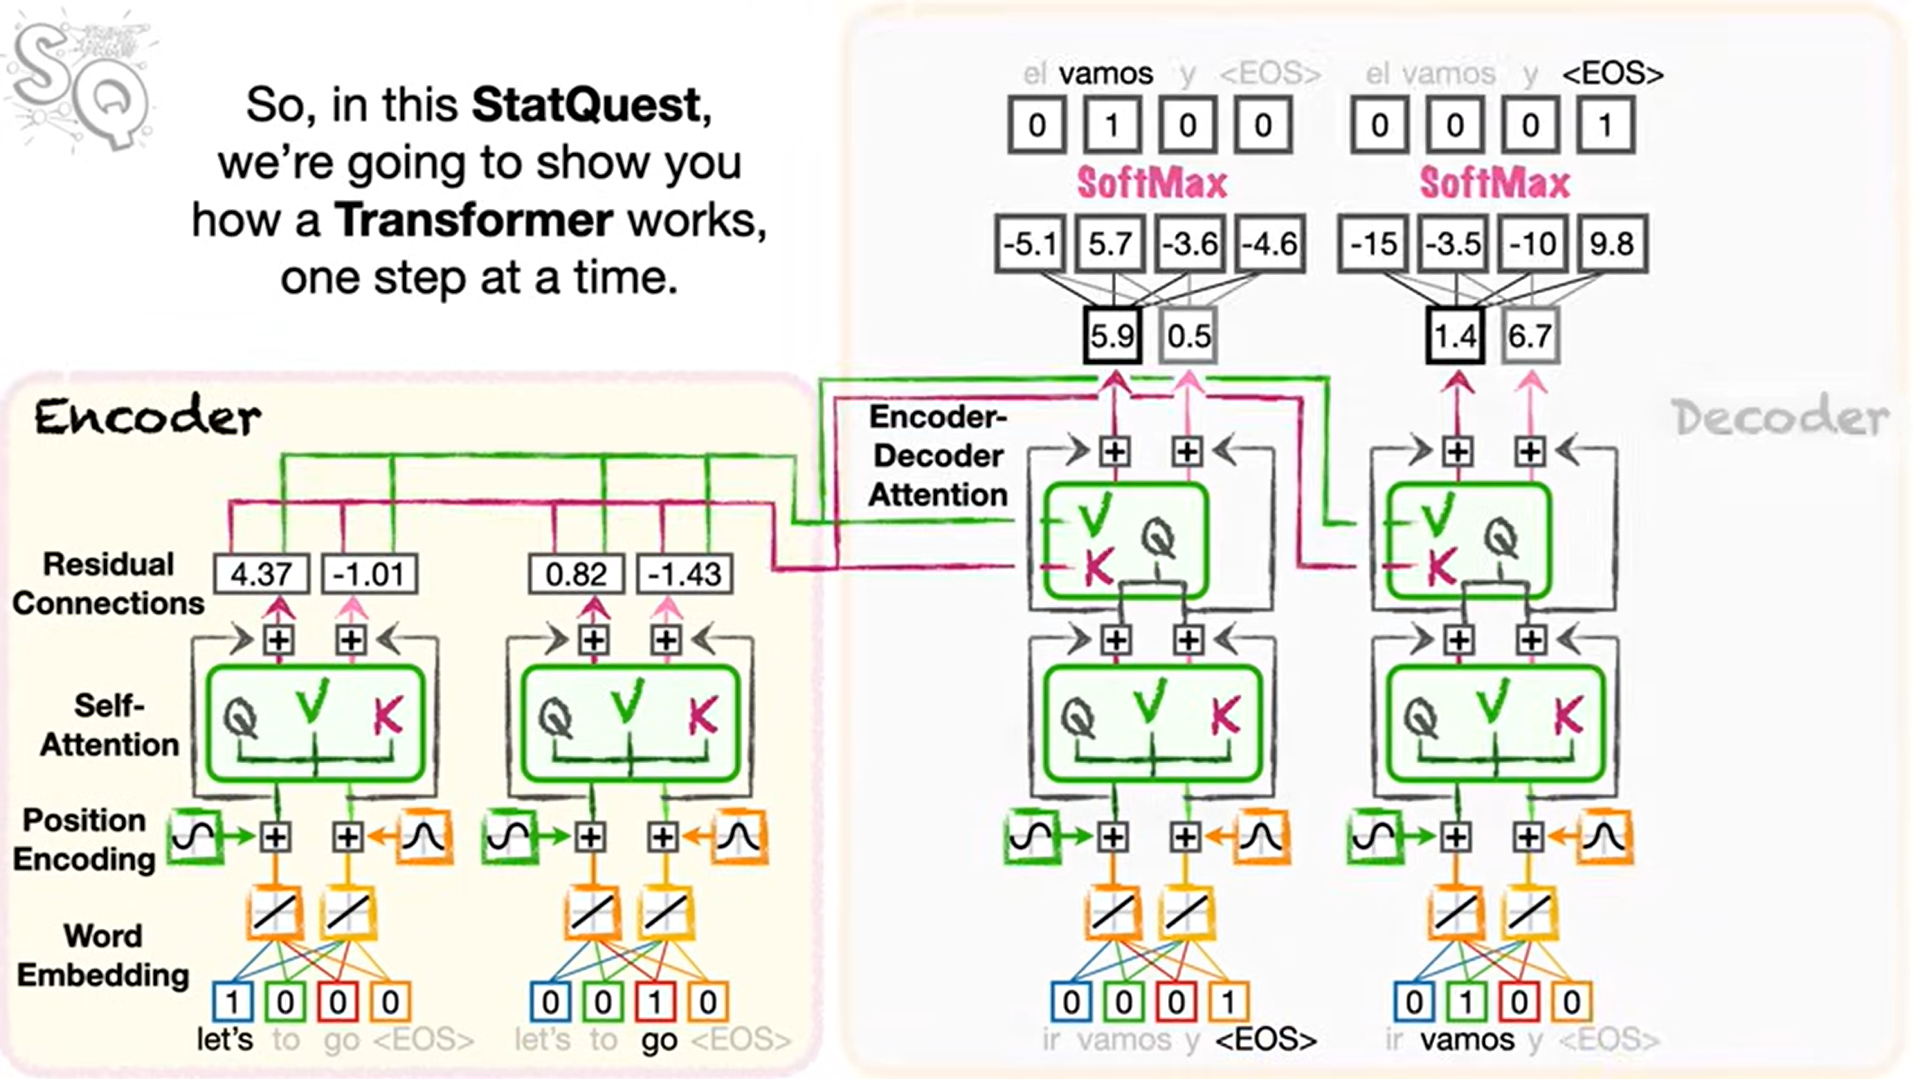



---



---

## 1. **Input Embedding:**

The first step is to convert the input data (e.g., words or tokens) into a continuous vector space using an embedding layer.

### From scratch:

In [ ]:
import torch
import torch.nn as nn

class EmbeddingLayer(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(EmbeddingLayer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)

    def forward(self, x):
        return self.embedding(x)

# Example usage
vocab_size = 10000  # Number of unique tokens
embed_dim = 512     # Embedding dimension size
input_tokens = torch.LongTensor([[1, 2, 3], [4, 5, 6]])

embedding_layer = EmbeddingLayer(vocab_size, embed_dim)
embedded_output = embedding_layer(input_tokens)
print(embedded_output.shape)  # Output shape: [batch_size, seq_len, embed_dim]


torch.Size([2, 3, 512])


### Bert example:

In [ ]:
!pip install transformers torch --quiet
from transformers import BertTokenizer, BertModel

# Loading the pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
model = BertModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

print(f"Loaded {model_name} model and tokenizer.")

Loaded bert-base-uncased model and tokenizer.


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Sample text
text = "Hello, world! This is an introduction to transformers."

# Tokenizing the text
tokens = tokenizer.tokenize(text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f"Tokens: {tokens}")
print(f"Token IDs: {token_ids}")

Tokens: ['hello', ',', 'world', '!', 'this', 'is', 'an', 'introduction', 'to', 'transformers', '.']
Token IDs: [7592, 1010, 2088, 999, 2023, 2003, 2019, 4955, 2000, 19081, 1012]


In [ ]:
# Encoding the text and getting model outputs
inputs = tokenizer.encode_plus(text, return_tensors="pt", add_special_tokens=True) # SOS and EOS tokens are added
outputs = model(**inputs)
print(
    "input_ids:", inputs["input_ids"], "\n",
    'token_type_ids:', inputs['token_type_ids'], "\n",
    'attention_mask:', inputs['attention_mask']
    )
# Example of extracting the last hidden state (features)
last_hidden_state = outputs.last_hidden_state

print(f"Shape of the last hidden state: {last_hidden_state.shape}") # Output shape: [batch_size, seq_len, embed_dim]

input_ids: tensor([[  101,  7592,  1010,  2088,   999,  2023,  2003,  2019,  4955,  2000,
         19081,  1012,   102]]) 
 token_type_ids: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]) 
 attention_mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
Shape of the last hidden state: torch.Size([1, 13, 768])



## **2. Positional Encoding:**

Since transformers don't inherently have a sense of sequence order (unlike RNNs), we need to inject position information to help the model distinguish between different token positions in the sequence.
check out this website to play with the positional embedding concept:
[understanding-positional-encoding-in-transformers](https://erdem.pl/2021/05/understanding-positional-encoding-in-transformers)

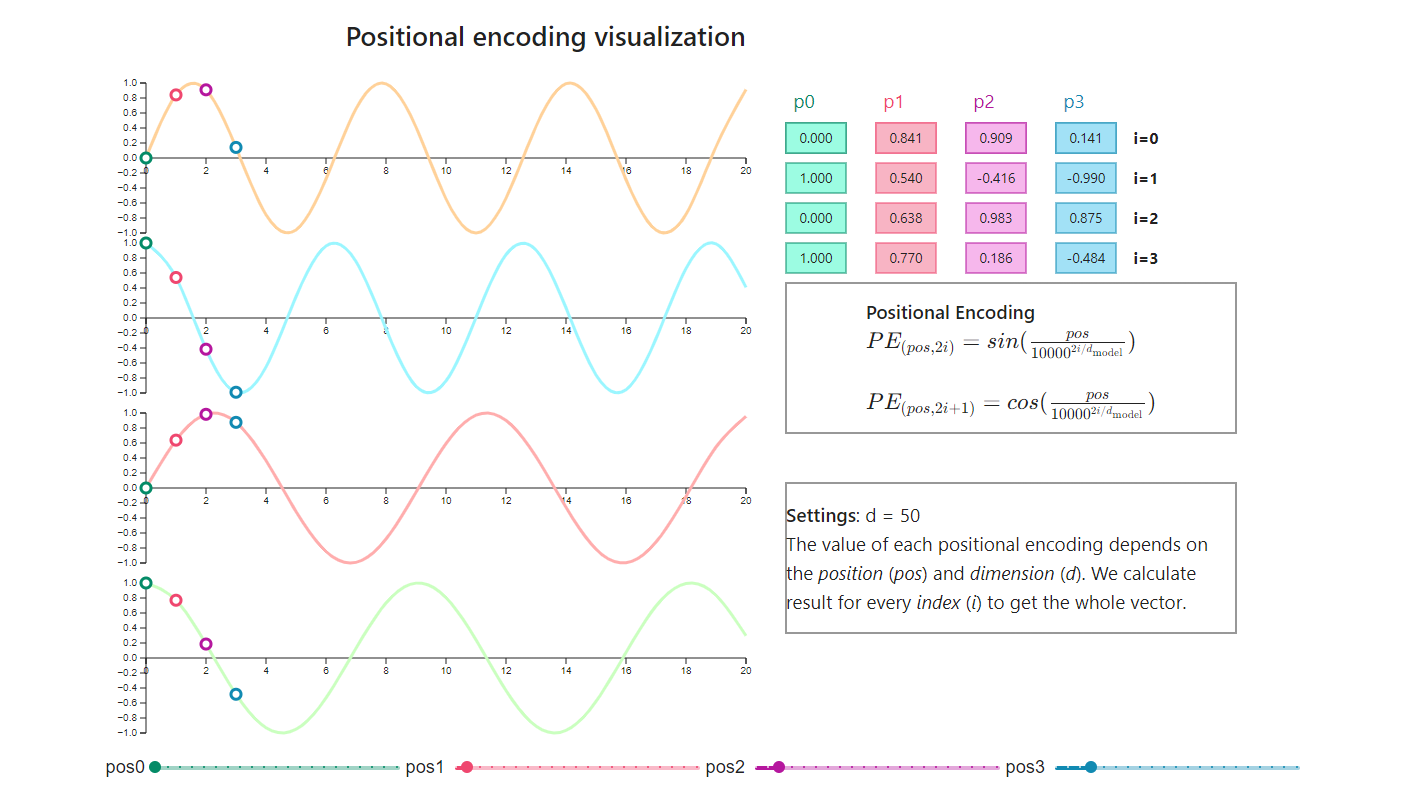

### From Scratch:

In [ ]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# Example usage
embed_dim = 512
pos_encoder = PositionalEncoding(embed_dim)
pos_encoded_output = pos_encoder(embedded_output)


## **3. Multi-Head Self-Attention**

The self-attention mechanism computes the relationships between each token and all other tokens in the sequence. Multi-head attention allows the model to attend to different parts of the sequence in parallel.

The core idea behind attention is the concept of Query (Q), Key (K), and Value (V) matrices:



*   **Query:** A representation of the token we are currently attending to.
*   **Key:** A representation of all tokens.
*   **Value:** The actual information stored in each token.
The attention score is computed as:

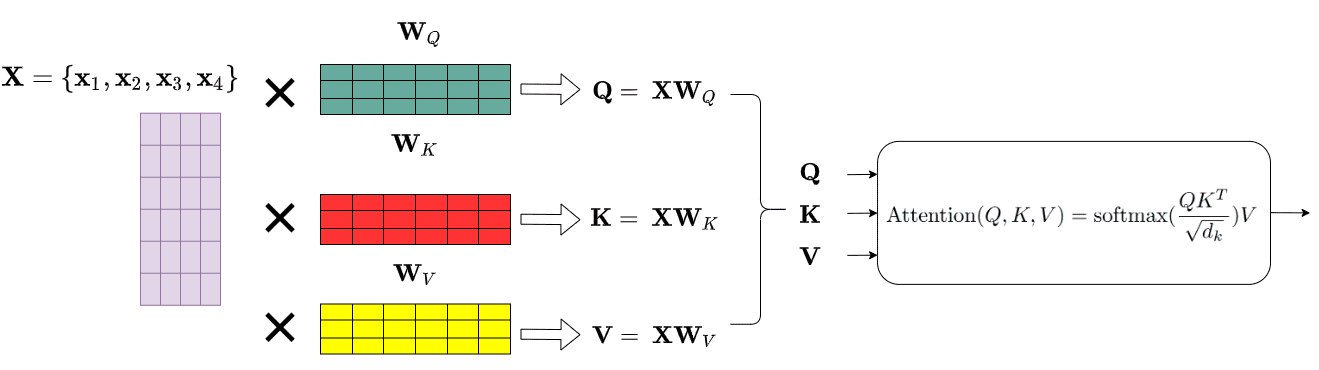


In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert embed_dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.fc_out = nn.Linear(embed_dim, embed_dim)

    def forward(self, values, keys, queries, mask=None):
        batch_size = queries.shape[0]

        # Linear transformations
        Q = self.query(queries)
        K = self.key(keys)
        V = self.value(values)

        # Reshape for multi-head
        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        # Scaled Dot-Product Attention
        attention_weights = torch.matmul(Q, K.transpose(-1, -2)) / math.sqrt(self.head_dim)
        if mask is not None:
            attention_weights = attention_weights.masked_fill(mask == 0, float('-inf'))
        attention = torch.softmax(attention_weights, dim=-1)

        # Apply attention to values
        out = torch.matmul(attention, V)

        # Concatenate heads and put through final linear layer
        out = out.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.head_dim)
        out = self.fc_out(out)
        return out

# Example usage
num_heads = 8
multi_head_attention = MultiHeadAttention(embed_dim, num_heads)
attn_output = multi_head_attention(pos_encoded_output, pos_encoded_output, pos_encoded_output)


## **4. Feed Forward Network**
Each token is passed through a feed-forward network, which is applied independently to each token. This is typically a simple two-layer MLP.

In [ ]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, embed_dim, ff_dim=2048):
        super(FeedForwardNetwork, self).__init__()
        self.fc1 = nn.Linear(embed_dim, ff_dim)
        self.fc2 = nn.Linear(ff_dim, embed_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

# Example usage
ffn = FeedForwardNetwork(embed_dim)
ffn_output = ffn(attn_output)


## **5. Residual Connections and Layer Normalization**
Residual connections are used to allow the gradient to flow through the network more easily during training. Layer normalization is applied to stabilize and speed up the training process.

In [ ]:
class TransformerLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim=2048):
        super(TransformerLayer, self).__init__()
        self.multi_head_attention = MultiHeadAttention(embed_dim, num_heads)
        self.feed_forward = FeedForwardNetwork(embed_dim, ff_dim)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x, mask=None):
        # Multi-head attention with residual connection
        attn_output = self.multi_head_attention(x, x, x, mask)
        x = self.norm1(x + attn_output)

        # Feed-forward network with residual connection
        ffn_output = self.feed_forward(x)
        x = self.norm2(x + ffn_output)
        return x

# Example usage
transformer_layer = TransformerLayer(embed_dim, num_heads)
output = transformer_layer(pos_encoded_output)


## **6. Encoder and Decoder Blocks**
The Transformer encoder is a stack of multiple layers like the one described above. The decoder is similar but includes an additional attention mechanism to attend to the encoder outputs.

**Encoder Block:**




In [ ]:
class Encoder(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers, ff_dim=2048):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([TransformerLayer(embed_dim, num_heads, ff_dim) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return x

# Example usage
num_layers = 6
encoder = Encoder(embed_dim, num_heads, num_layers)
encoder_output = encoder(pos_encoded_output)


**Decoder Block:**

The decoder is similar but uses an additional attention mechanism to attend to the encoder output while decoding.

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim=2048):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(embed_dim, num_heads)
        self.enc_dec_attention = MultiHeadAttention(embed_dim, num_heads)
        self.feed_forward = FeedForwardNetwork(embed_dim, ff_dim)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.norm3 = nn.LayerNorm(embed_dim)

    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        # Self-attention for the target sequence
        attn_output = self.self_attention(x, x, x, tgt_mask)
        x = self.norm1(x + attn_output)

        # Encoder-decoder attention
        enc_attn_output = self.enc_dec_attention(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + enc_attn_output)

        # Feed-forward network
        ffn_output = self.feed_forward(x)
        x = self.norm3(x + ffn_output)
        return x

# Decoder example (for translation tasks)
decoder_layer = DecoderLayer(embed_dim, num_heads)
decoder_output = decoder_layer(pos_encoded_output, encoder_output)
